In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
#Clear output
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

trainDataset = torchvision.datasets.FashionMNIST("fashionDataset", train=True, download=True, transform=transforms.ToTensor())
testDataset = torchvision.datasets.FashionMNIST("fashionTrain", train=False, download=True, transform=transforms.ToTensor())

cuda


In [2]:
mapping = trainDataset.targets == 0

trousers = trainDataset.data[mapping]
trousers = trousers.unsqueeze(1)
trousers = trousers.float()
trousers.shape


torch.Size([6000, 1, 28, 28])

In [3]:
BATCH_SIZE = 1000
EPOCHS = 50
LEARNING_RATE = 0.00005
alphaG = 0.00005
alphaD = 0.00005

dataloader = DataLoader(trousers, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 5, 2, 2, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, 5, 2, 2, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, 5, 2, 2, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.reshape(-1, 1)
        return x
    
D = Discriminator()
D = D.to(device)
D(torch.randn(1, 1, 28, 28).to(device))
    
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(100, 256*7*7, bias=False),
            torch.nn.ReLU(inplace=True),
        )
        self.convT1 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(256, momentum=0.1, affine=True),
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
        )
        self.convT2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc1(x)
        x = x.reshape(-1, 256, 7, 7)
        x = self.convT1(x)
        x = self.convT2(x)
        return x

G = Generator().to(device)

G(torch.randn(1, 100).to(device)).shape


# noise = torch.randn(5, 10)
# noise = noise.to(device)
# generator = Generator()
# generator = generator.to(device)
# fake= generator(noise)

# discriminator = Discriminator()
# discriminator = discriminator.to(device)
# pred = discriminator(fake)
# pred


torch.Size([1, 1, 28, 28])

In [5]:
loss_discriminator = torch.nn.BCELoss()

discriminator = Discriminator().to(device)
generator = Generator().to(device)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=alphaD)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=alphaG)

In [6]:
#Print number of params
print("Generator params: ", sum(p.numel() for p in generator.parameters() if p.requires_grad))
print("Discriminator params: ", sum(p.numel() for p in discriminator.parameters() if p.requires_grad))

Generator params:  1781504
Discriminator params:  927328


Epoch: 49
Loss of discriminator:  3.6254928559064865
Loss of generator:  5.150937058031559


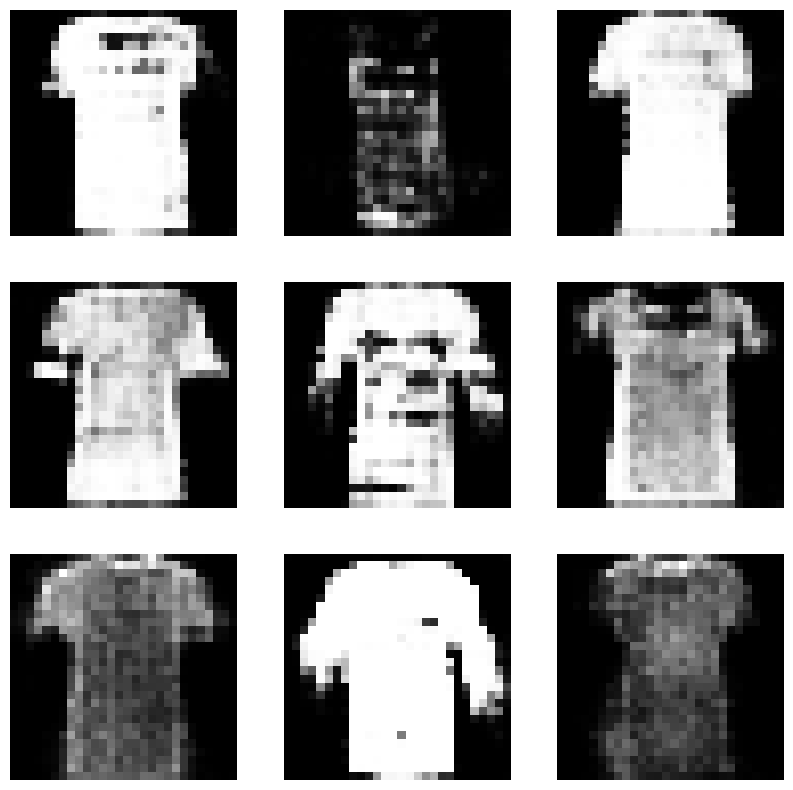

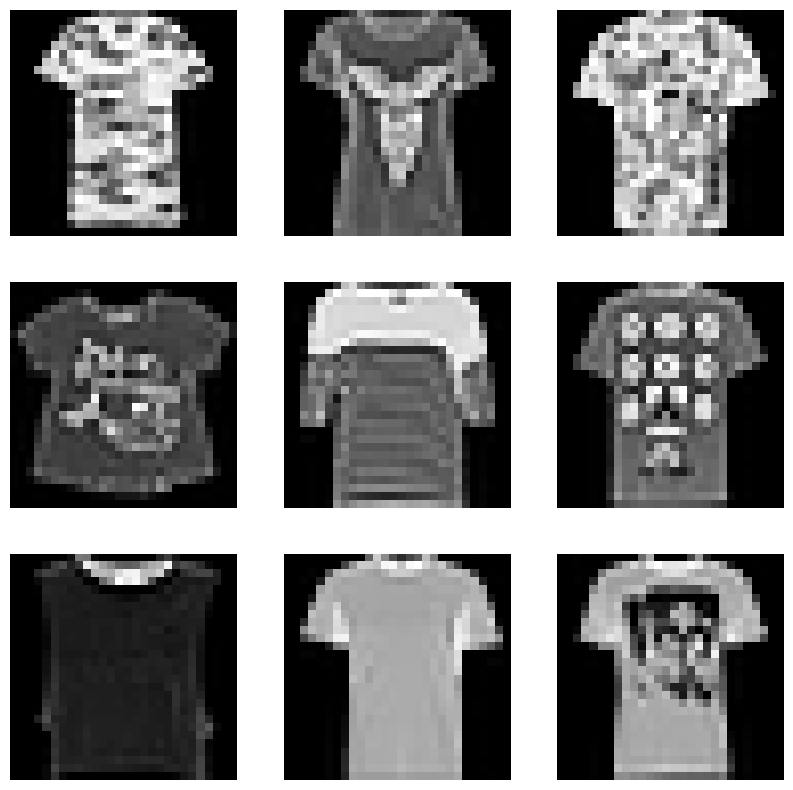

In [9]:
for epoch in range(EPOCHS):

    lossOfDiscriminator = 0
    lossOfGenerator = 0



    while True:
        avgLoss = 0
        for i, realImage in enumerate(dataloader):
            optimizer_discriminator.zero_grad()
            realImage = realImage.to(device)

            realLabel = torch.ones(BATCH_SIZE, 1).float().to(device)
            fakeLabel = torch.zeros(BATCH_SIZE, 1).float().to(device)

            noise = torch.randn(BATCH_SIZE, 100).to(device)
            fakeImage = generator(noise)

            pred_real = discriminator(realImage)
            pred_fake = discriminator(fakeImage)
            loss_real = loss_discriminator(pred_real, realLabel)
            loss_fake = loss_discriminator(pred_fake, fakeLabel)
            loss = loss_real + loss_fake
            loss.backward()
            optimizer_discriminator.step()
            lossOfDiscriminator += loss.item()
            avgLoss += loss.item()
        #print("Loss of discriminator: ", avgLoss/len(dataloader))
        if avgLoss/len(dataloader) < 0.1:
            break

            # if i % 5 == 0:
            #     print("Loss: ", loss.item())

    
    while True:
        avgLoss = 0
        for i, realImage in enumerate(dataloader):
            optimizer_generator.zero_grad()
            realImage = realImage.to(device)

            faketargets = torch.ones(BATCH_SIZE, 1).float().to(device)

            noise = torch.randn(BATCH_SIZE, 100).to(device)
            fakeImage = generator(noise)

            pred_fake = discriminator(fakeImage)

            fake_loss = loss_discriminator(pred_fake, faketargets)
            loss = fake_loss
            loss.backward()
            optimizer_generator.step()
            lossOfGenerator += loss.item()
            avgLoss += loss.item()
        #print("Loss of generator: ", avgLoss/len(dataloader))
        if avgLoss/len(dataloader) < 0.1:
            break

        # if i % 5 == 0:
        #     print("Loss: ", loss.item())
    print("Epoch:",epoch)
    print("Loss of discriminator: ", lossOfDiscriminator/len(dataloader))
    print("Loss of generator: ", lossOfGenerator/len(dataloader))


    noise = torch.randn(9, 100).to(device)
    fakeImage = generator(noise)

    y_pred = discriminator(fakeImage)
    y_pred = torch.softmax(y_pred, dim=1)

    #Show generator output
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        for j in range(3):
            ax[i, j].imshow(fakeImage[i*3+j].detach().cpu().reshape(28, 28), cmap='gray')
            ax[i, j].axis('off')
    
    plt.show()

    #Show real image

    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        for j in range(3):
            #chose random image
            index = np.random.randint(0, len(trousers))
            ax[i, j].imshow(trousers[index].reshape(28, 28), cmap='gray')
            ax[i, j].axis('off')

    plt.show()

    clear_output(wait=True)

    

In [113]:
#Test

noise = torch.randn(1, 100).to(device)
fakeImage = generator(noise)

y_pred = discriminator(fakeImage)
y_pred = torch.softmax(y_pred, dim=1)

print(y_pred)

tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


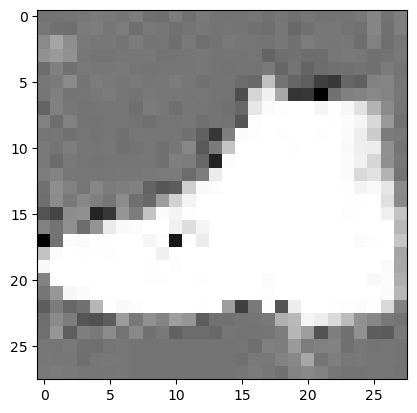

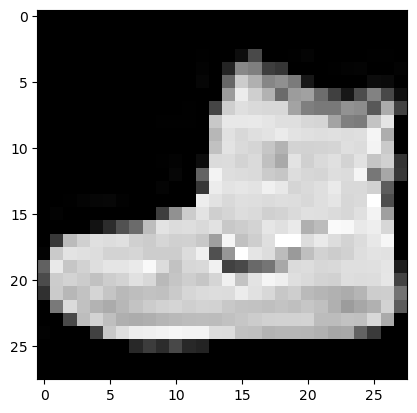

-0.8396365
tensor(0.)


In [114]:
#Show generator output

fakeImage = fakeImage.reshape(28, 28)
fakeImage = fakeImage.detach().cpu().numpy()
plt.imshow(fakeImage, cmap='gray')
plt.show()

#Show real image

realImage = trousers[0]
realImage = realImage.reshape(28, 28)
plt.imshow(realImage, cmap='gray')
plt.show()

print(min(fakeImage.reshape(-1)))
print(min(realImage.reshape(-1)))

In [ ]:
saving = False
if saving:
    torch.save(generator.state_dict(), "generatorA.pt")
    torch.save(discriminator.state_dict(), "discriminatorA.pt")

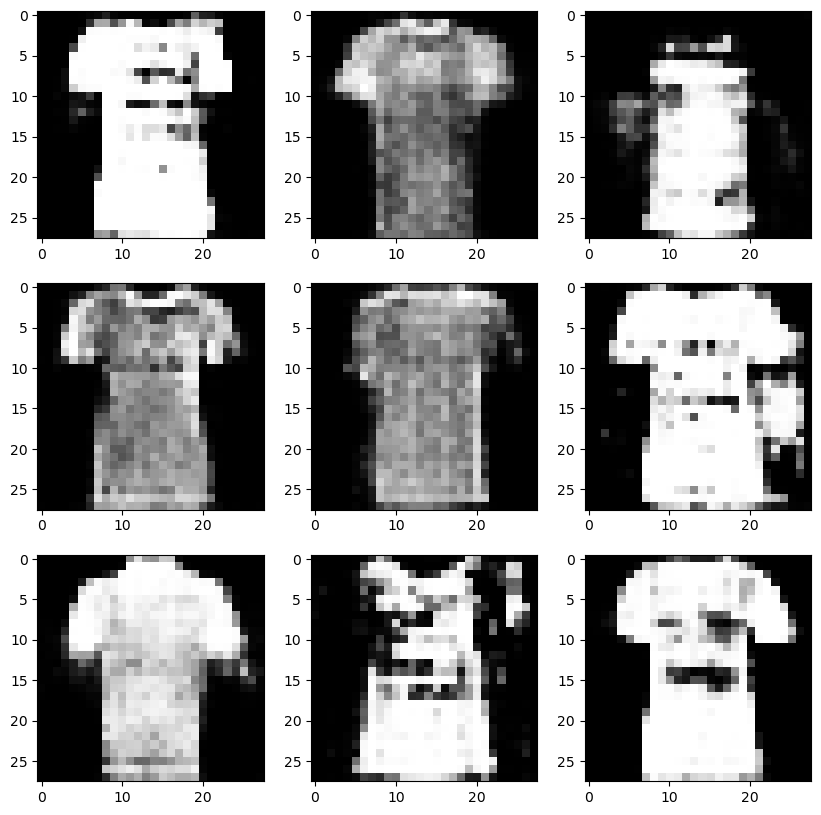

In [19]:
#Show grid of generated images

noise = torch.randn(9, 100).to(device)
fakeImage = generator(noise)

fakeImage = fakeImage.reshape(9, 28, 28)
fakeImage = fakeImage.detach().cpu().numpy()

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(fakeImage[i*3+j], cmap='gray')